### Step 0 - Generate data.csv from get_data.py

```bash
$ python get_data.py
```

In [50]:
# Import the libraries

import pandas as pd
import math
from sklearn.model_selection import train_test_split

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

## Neural network
# import tensorflow as tf

### Step 1 - Get the data and preprocess it

In [51]:
# Import data.csv
data = pd.read_csv('data.csv')

# Display only certains columns to have better display
# (missing columns: Nb_Parents, Nb_Children, Has_Nb_Parents_And_Children, Has_Definition, TUI_Index)
data.loc[:,['Label', 'Source', 'Definition', 'TUI']].head()

,Label,Source,Definition,TUI
0,synthetic 11-hydroxycorticosteroids,AOD,NaN,T109
1,synthetic 11-hydroxycorticosteroids,AOD,NaN,T121
2,17-Hydroxysteroid Dehydrogenases,AOD,A class of enzymes that catalyzes the oxidatio...,T116
3,17-Hydroxysteroid Dehydrogenases,AOD,A class of enzymes that catalyzes the oxidatio...,T126
4,mesna,ATC,A sulfhydryl compound used to prevent urotheli...,T109


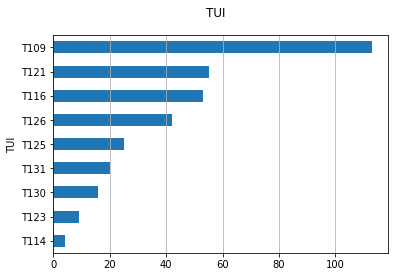

In [52]:
# Plotting the univariate distribution of the data

fig, ax = plt.subplots()
fig.suptitle("TUI", fontsize=12)
data["TUI"].reset_index().groupby("TUI").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

The graph shows that there are differences of distributions between the TUIs

In [59]:
# Picture of the difference between stemming and lemmitization: https://miro.medium.com/max/1400/1*ES5bt7IoInIq2YioQp2zcQ.png

# TODO Upgrade preprocessing -> special for biomedical data

def utils_preprocessing_corpus(text, stopwords=None, stemming=False, lemmitization=False):
    """This function prepare the corpus for the model.
    It can remove stopwords, lemmatize or stemming.

    Args:
        text (str): corpus to be processed
        stopwords (List[str], optional): stopwords to remove. Defaults to None.
        stemming (bool, optional): process stemming. Defaults to False.
        lemmitization (bool, optional): process lemmitization. Defaults to False.
    """
    # Check if the text is NaN
    if text != text:
        return ""
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.replace('[^\w\s]','').strip()
    # Tokenize
    text = text.split()
    # Remove stopwords
    if stopwords:
        text = [word for word in text if word not in stopwords]
    ## Lemmatisation (convert the word into root word)
    if lemmitization == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text]
    ## Stemming (remove -ing, -ly, ...)
    if stemming == True:
        ps = nltk.stem.porter.PorterStemmer()
        text = [ps.stem(word) for word in text]
    # Join the list of words
    text = " ".join(text)
    return text

stopwords = nltk.corpus.stopwords.words("english")
data.loc[:,"Clean_Definition"] = data.loc[:,"Definition"].apply(utils_preprocessing_corpus, args=(stopwords, False, True))

# Show 10 random rows
data.loc[:,['Definition', 'Clean_Definition']].sample(10)

,Definition,Clean_Definition
175,A dye used as a reagent in the determination o...,dye used reagent determination vitamin c.
108,NaN,
149,"Nucleoside-2',3'-cyclic phosphate nucleotidohy...","nucleoside-2',3'-cyclic phosphate nucleotidohy..."
283,A group of hydroxycorticosteroids bearing a hy...,group hydroxycorticosteroids bearing hydroxy g...
9,A group of hydroxycorticosteroids bearing a hy...,group hydroxycorticosteroids bearing hydroxy g...
318,An herbicide with strong irritant properties. ...,herbicide strong irritant properties. use comp...
284,A group of hydroxycorticosteroids bearing a hy...,group hydroxycorticosteroids bearing hydroxy g...
186,A metabolite in the principal biochemical path...,metabolite principal biochemical pathway lysin...
188,A metabolite in the principal biochemical path...,metabolite principal biochemical pathway lysin...
67,NaN,
